# ESiWACE3 Compression Lab in WebAssembly

**Note:** Any changes you make to this notebook will be lost once the page is closed or refreshed. Please download any files you would like to keep.

**Note:** The WASM-based version of the compression lab running inside JupyterLite has only been tested in recent Firefox browsers.

## Import the ESiWACE3 field compression benchmarking library

Importing `fcbench` also imports a large number of dependencies, which may take around a minute. Why not use this time to grab a drink, stretch your legs, and look out of your window?

In [1]:
import fcbench

[pyodide]: Loading field-compression-benchmark, cfgrib, attrs, click, eccodes, cffi, pycparser, findlibs, xarray, pandas, tzdata, dask, cloudpickle, importlib_metadata, zipp, Jinja2, MarkupSafe, partd, locket, toolz, pyyaml, netcdf4, cftime, certifi, h5py, pkgconfig, numcodecs, msgpack, pint, typing-extensions, xeofs, pooch, lzma, platformdirs, requests, charset-normalizer, idna, urllib3, scikit-learn, scipy, openblas, joblib, distutils, threadpoolctl, statsmodels, patsy, tqdm, xarray-datatree, zarr, asciitree, xhistogram
[pyodide]: Loaded Jinja2, MarkupSafe, asciitree, attrs, certifi, cffi, cfgrib, cftime, charset-normalizer, click, cloudpickle, dask, distutils, eccodes, field-compression-benchmark, findlibs, h5py, idna, importlib_metadata, joblib, locket, lzma, msgpack, netcdf4, numcodecs, openblas, pandas, partd, patsy, pint, pkgconfig, platformdirs, pooch, pycparser, pyyaml, requests, scikit-learn, scipy, statsmodels, threadpoolctl, toolz, tqdm, typing-extensions, tzdata, urllib3, 

Many Python packages that are common in scientific computing and meteorology are available in this lab and can simply be imported. These include, e.g., `cartopy`, `cfgrib`, `dask`, `earthkit`, `matplotlib`, `metpy`, `netcdf4`, `numcodecs`, `numpy`, `pandas`, `xarray`, and `zarr`.

If you want to use a package that fails to import, you can first try to install it from PyPi by running a code cell similar to the following, which installs `tqdm`:

In [2]:
%pip install tqdm
import tqdm

Note that this installation only works for *pure* Python packages, i.e. those that only include Python code and only have pure or pre-installed dependencies. If you cannot install your packages this way, please tell us about the missing package in the feedback form below:

https://forms.office.com/e/hKqfmvFTkz

## Define some utility functions for loading and saving datasets

In [3]:
import shutil
import uuid
from contextlib import asynccontextmanager
from pathlib import Path
from typing import Optional, Union
from urllib.parse import unquote as urlunquote
from urllib.parse import urlparse
from urllib.request import urlopen

import dask
import ipyfilite
import xarray as xr
import zarr
from numcodecs.abc import Codec

dask.config.set(array__chunk_size="32MiB")


def open_dataset(path: Path, **kwargs) -> xr.Dataset:
    if path.suffix == ".grib" or kwargs.get("engine", None) == "cfgrib":
        if "engine" not in kwargs:
            kwargs["engine"] = "cfgrib"
        if "backend_kwargs" not in kwargs:
            kwargs["backend_kwargs"] = dict()
        if "indexpath" not in kwargs["backend_kwargs"]:
            # cfgrib creates index files right next to the data file,
            #  which may be in a read-only file system
            kwargs["backend_kwargs"]["indexpath"] = ""

    if "".join(path.suffixes).endswith(".zarr.zip"):
        if "engine" not in kwargs:
            kwargs["engine"] = "zarr"

    if "chunks" not in kwargs:
        kwargs["chunks"] = "auto"

    if "cache" not in kwargs:
        kwargs["cache"] = False

    ds = xr.open_dataset(str(path), **kwargs)
    ds.attrs["path"] = str(path)

    return ds


async def mount_user_local_file() -> Path:
    uploader = ipyfilite.FileUploadLite()
    await uploader.request()
    uploader.close()

    return uploader.value[0].path


def mount_http_file(url: str, name: Optional[str] = None) -> Path:
    if name is None:
        name = _get_name_from_url(url)

    http_file = ipyfilite.HTTPFileIO(name=name, url=url)

    return http_file.path


def fetch_small_http_file(url: str, name: Optional[str] = None) -> Path:
    if name is None:
        name = _get_name_from_url(url)

    # FIXME: implement /scratch using the origin private file system with auto-cleanup
    small_path = Path("/scratch") / str(uuid.uuid4()) / name
    small_path.parent.mkdir(parents=True, exist_ok=False)

    with urlopen(url) as response:
        with small_path.open("wb") as file:
            shutil.copyfileobj(response, file)

    return small_path


def _get_name_from_url(url: str) -> str:
    return urlunquote(Path(urlparse(url).path).name)


async def download_dataset_as_zarr(
    ds: xr.Dataset,
    name: str,
    compressor: Union[
        Codec, list[Codec], dict[str, Union[Codec, list[Codec]]]
    ],
    zip_compression: int = 0,
):
    name_suffix = "".join(Path(name).suffixes)

    # Ensure that the file path is easily recognisable as a zipped zarr file
    if name_suffix.endswith(".zarr.zip"):
        pass
    elif name_suffix.endswith(".zarr"):
        name = f"{name}.zip"
    elif name_suffix.endswith(".zip"):
        name = f"{Path(name).stem}.zarr.zip"
    else:
        name = f"{name}.zarr.zip"

    async with ipyfilite.FileDownloadPathLite(name) as path:
        store = zarr.storage.MemoryStore()
        chunk_store = zarr.storage.ZipStore(
            str(path),
            compression=zip_compression,
            allowZip64=True,
            mode="x",
        )

        compressors = (
            compressor
            if isinstance(compressor, dict)
            else {var: compressor for var in ds}
        )

        encoding = dict()
        for var, compressor in compressors.items():
            if isinstance(compressor, list):
                if len(compressor) == 0:
                    continue
                encoding[var] = dict(
                    compressor=compressor[0],
                    filters=compressor[1:],
                )
            else:
                encoding[var] = dict(
                    compressor=compressor,
                    filters=[],
                )

        ds.to_zarr(store=store, mode="w-", encoding=encoding)

        for key in store.keys():
            chunk_store[key] = store[key]

        store.close()
        chunk_store.close()


@asynccontextmanager
async def file_download_path(name: str) -> Path:
    try:
        async with ipyfilite.FileDownloadPathLite(name) as path:
            yield path
    finally:
        pass

[pyodide]: Loading ipyfilite, ipywidgets, widgetsnbextension, jupyterlab_widgets
[pyodide]: Loaded ipyfilite, ipywidgets, jupyterlab_widgets, widgetsnbextension


In [4]:
import numcodecs
import pandas as pd

def format_compress_stats(codecs: list[numcodecs.abc.Codec], stats: list[fcbench.compressor.types.CodecPerformanceMeasurement]):
    table = pd.DataFrame(
        {
            "Codec": [],
            "compression ratio [raw B / enc B]": [],
            "encode throughput [raw GB/s]": [],
            "decode throughput [raw GB/s]": [],
            "encode instructions [#/B]": [],
            "decode instructions [#/B]": [],
        }
    ).set_index(["Codec"])

    for codec, stat in zip(codecs, stats):
        table.loc[str(codec),:] = [
            round(stat.decoded_bytes / stat.encoded_bytes, 2),
            round(1e-9 * stat.decoded_bytes / (stat.encode_timing.secs + stat.encode_timing.nanos * 1e-9), 2),
            round(1e-9 * stat.decoded_bytes / (stat.decode_timing.secs + stat.decode_timing.nanos * 1e-9), 2),
            round(stat.encode_instructions / stat.decoded_bytes, 1),
            round(stat.decode_instructions / stat.decoded_bytes, 1),
        ]

    return table

## Fetch an example dataset

### (a) Download a small dataset into memory

Small datasets can be downloaded and saved in the in-memory file system of this JupyterLite notebook. Note, however, that memory is limited.

In [5]:
small_path = fetch_small_http_file(
    "https://lab.climet.eu/data/hplp_ml_q_dx=2.0.grib"
)
small_path

PosixPath('/scratch/17356ee2-002e-4e83-a55a-792a8955e9bb/hplp_ml_q_dx=2.0.grib')

### (b) Mount a large dataset from the user's filesystem

Alternatively, you can also upload a dataset file from your own computer. The file is mounted in read-only mode into the notebook's file system without reading the file into memory, thus allowing arbitrarily large files to be made accessible. It is worth remembering that large files can still only be read if the algorithm that processes them supports streaming or chunking and does not request to load all data into memory at the same time.

If this notebook is run inside JupyterLite, the file also never leaves your own computer.

Note that this code is commented out since it requires your user input to upload a file and progress through the code. To mount an uploaded file, uncomment the following code cell and run it.

In [6]:
# upload_path = await mount_user_local_file()
# upload_path

Once you have selected a file to upload, you can retrieve the path at which the file is now mounted in read-only mode.

### (c) Mount a large dataset from a URL that supports HTTP Range Requests

Similarly, you can also mount a file from a URL. The file is mounted in read-only mode into the notebook's file system without reading the file into memory, thus allowing arbitrarily large files to be made accessible.

Note that the HTTP endpoint at the URL must support [range requests](https://developer.mozilla.org/en-US/docs/Web/HTTP/Range_requests) and serve the file without compression so that small chunks of the file can be loaded only when requested. If the dataset is hosted at a different HTTP [origin](https://developer.mozilla.org/en-US/docs/Glossary/Origin) than this compression lab, it must also support [Cross-Origin Resource Sharing](https://developer.mozilla.org/en-US/docs/Web/HTTP/CORS).

It is also worth remembering that large files can still only be read if the algorithm that processes them supports streaming or chunking and does not request to load all data into memory at the same time.

In [7]:
http_path = mount_http_file(
    "https://lab.climet.eu/data/hplp_ml_q_dx=2.0.grib"
)
http_path

PosixPath('/http/66d5ba37-2c6c-4668-aa63-4e788a32349d/hplp_ml_q_dx=2.0.grib')

## Load the example dataset into `xarray`

To select which dataset you wish to load, only execute one of the following three lines.

Afterwards, we load the dataset into `xarray`.
```python
open_dataset(path: pathlib.Path, **kwargs) -> xarray.Dataset
```
is a thin wrapper around
```python
xarray.open_dataset(filename: str, **kwargs) -> xarray.Datset
```
and thus takes the same arguments. Please refer to the [`xarray.open_dataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) documentation if you need to perform some special configuration.

In [8]:
dataset_path = small_path
# dataset_path = upload_path
# dataset_path = http_path

ds = open_dataset(dataset_path)
ds

<xarray.Dataset>
Dimensions:     (hybrid: 10, latitude: 91, longitude: 180)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * latitude    (latitude) float64 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
  * longitude   (longitude) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
    valid_time  datetime64[ns] ...
Data variables:
    q           (hybrid, latitude, longitude) float64 dask.array<chunksize=(10, 91, 180), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-20T20:06 GRIB to CDM+CF via cfgrib-0.9.1...
    path:                    /scratch/17356ee2-002e-4e83-a55a-792a8955e9bb/hp...

## Plot the loaded dataset

In [9]:
import earthkit

[pyodide]: Loading earthkit, earthkit-data, entrypoints, filelock, jsonschema, pyrsistent, markdown, multiurl, pdbufr, earthkit-meteo, earthkit-maps, Cartopy, shapely, pyshp, pyproj, geos, adjustText, earthkit-plots, plotly, earthkit-regrid
[pyodide]: Loaded Cartopy, adjustText, earthkit, earthkit-data, earthkit-maps, earthkit-meteo, earthkit-plots, earthkit-regrid, entrypoints, filelock, geos, jsonschema, markdown, multiurl, pdbufr, plotly, pyproj, pyrsistent, pyshp, shapely


/lib/python3.11/site-packages/earthkit/regrid/utils/caching.py:27: UserWarning: only soft file lock is available
  from filelock import FileLock


We first plot the loaded dataset. `earthkit` provides the
```python
earthkit.maps.quickplot(
    *data, blueprint=..., units=None, style=None, disjoint=False, show=True, **kwargs
) -> matplotlib.figure.Figure
```
helper function to plot weather and climate maps data.

In our example, we plot the specific humidity variable `q` on the first hybrid layer from the dataset.

In [10]:
da = ds["q"].sel(dict(hybrid=1))

/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


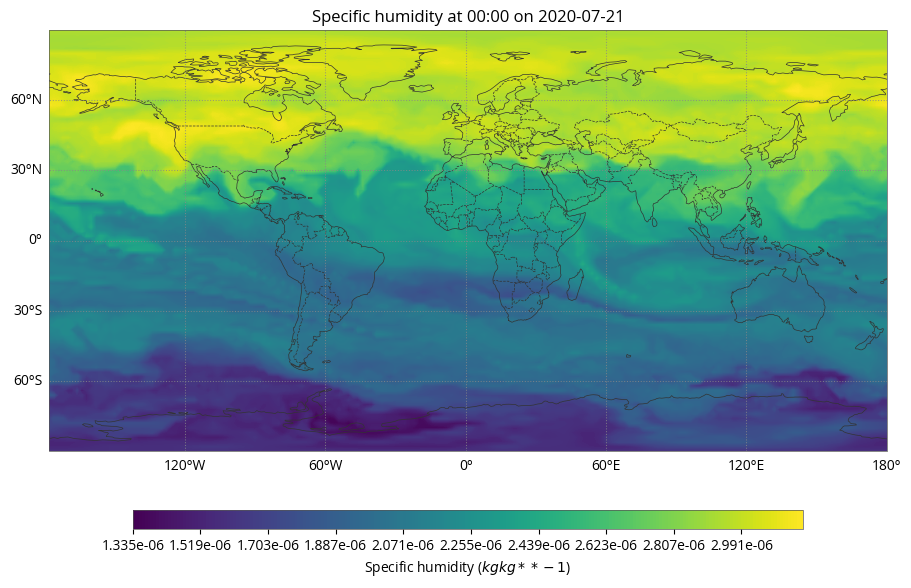

In [11]:
earthkit.maps.quickplot(da, style=earthkit.maps.Style(
    colors="viridis",
    levels=earthkit.maps.styles.levels.auto_range(da, n_levels=256),
));

## Comparing several different compression methods

`fcbench` provides some helper functions to compress your data with codecs implementing the `numcodecs` API. `fcbench.codecs` also comes with built-in support for several compression codecs, which we first have to preload.

In [12]:
fcbench.codecs.preload()

Loaded the fcbench.codecs.BitRound codec ...
Loaded the fcbench.codecs.BitTranspose codec ...
Loaded the fcbench.codecs.Identity codec ...
Loaded the fcbench.codecs.LinearQuantize codec ...
Loaded the fcbench.codecs.Log codec ...
Loaded the fcbench.codecs.Reinterpret codec ...
Loaded the fcbench.codecs.Round codec ...
Loaded the fcbench.codecs.Sz3 codec ...
Loaded the fcbench.codecs.UniformNoise codec ...
Loaded the fcbench.codecs.Zfp codec ...
Loaded the fcbench.codecs.Zlib codec ...
Loaded the fcbench.codecs.Zstd codec ...


## Run a simple Linear Quantization compressor

One of the codecs included in `fcbench.codecs` is the simple lossy `LinearQuantize` codec that rescales real-valued data from $[min; max]$ to the integer range $[0; 2^b - 1]$. Here, $b$ is the number of bit precision you want to keep.

In [13]:
simple_compressor = [fcbench.codecs.LinearQuantize(bits=4, dtype="float64")]
da_simple, stats_simple = fcbench.compressor.compute_dataarray_compress_decompress(da, simple_compressor)
format_compress_stats(simple_compressor, stats_simple)

compression ratio [raw B / enc B]  \
Codec                                                                        
LinearQuantize(dtype='float64', bits=4)                               7.99   

                                         encode throughput [raw GB/s]  \
Codec                                                                   
LinearQuantize(dtype='float64', bits=4)                          0.06   

                                         decode throughput [raw GB/s]  \
Codec                                                                   
LinearQuantize(dtype='float64', bits=4)                          0.18   

                                         encode instructions [#/B]  \
Codec                                                                
LinearQuantize(dtype='float64', bits=4)                        3.2   

                                         decode instructions [#/B]  
Codec                                                               
LinearQuantize(dtype='float64', bits=4)                        1.0

After you have finished using a compressor, it is important to overwrite or delete it to allow its resources to be reused.

In [14]:
del simple_compressor

When we plot the compressed data, we can see that it has indeed been quantized to $2^4 = 16$ values (per data chunk).

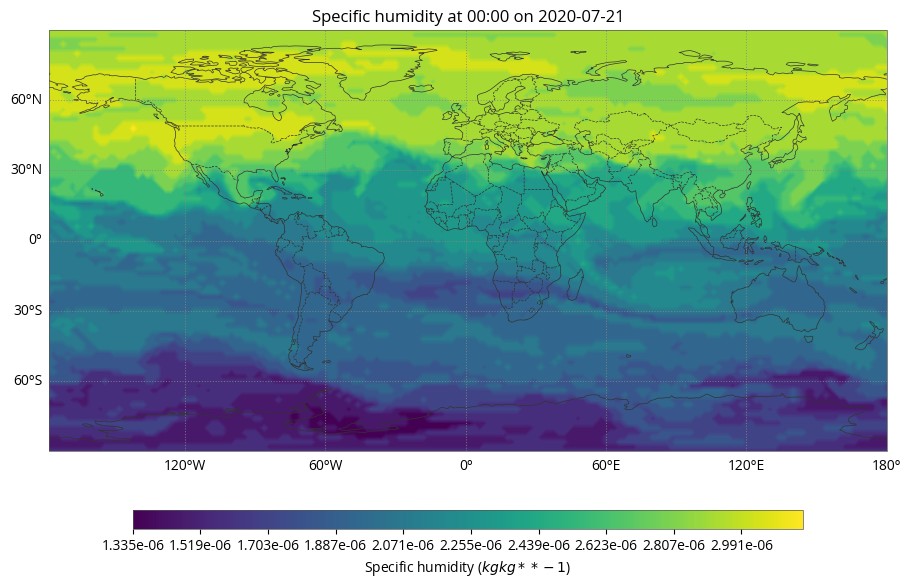

In [15]:
earthkit.maps.quickplot(da_simple, style=earthkit.maps.Style(
    colors="viridis",
    levels=earthkit.maps.styles.levels.auto_range(da_simple, n_levels=256),
));

## Plot the simple compression error

/lib/python3.11/site-packages/earthkit/maps/metadata/__init__.py:89: UserWarning: No key "variable_name" found in layer metadata.
  warnings.warn(f'No key "{attr}" found in layer metadata.')
/lib/python3.11/site-packages/earthkit/maps/metadata/__init__.py:89: UserWarning: No key "units" found in layer metadata.
  warnings.warn(f'No key "{attr}" found in layer metadata.')


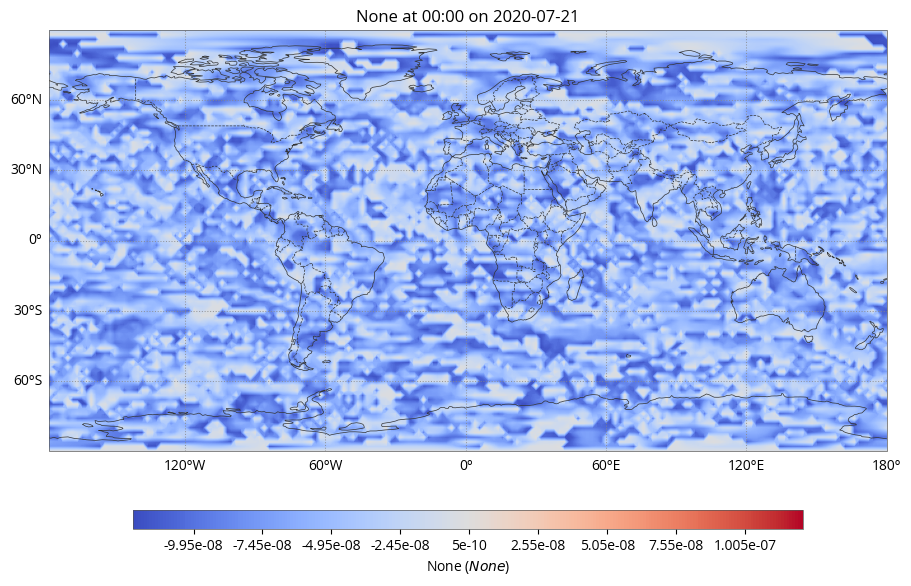

In [16]:
da_simple_error = da_simple - da
earthkit.maps.quickplot(da_simple_error, style=earthkit.maps.Style(
    colors="coolwarm",
    levels=earthkit.maps.styles.levels.auto_range(da_simple_error, n_levels=256, divergence_point=0.0),
));

## Run the transform-based ZFP compressor

ZFP is a lossy transform-based compressor that compresses multidimensional data in $4^d$ chunks where $d$ is the dimensionality of the data. All values in the chunk are decorrelated and then transformed into a binary plane embedding that is roughly ordered by importance. The resulting per-chunk bitstream can be truncated to satisfy a user-provided compression target, e.g. a fixed number of bits, a bitplane precision, or an absolute error tolerance.

You can find out more about the ZFP compressor in its [documentation](https://zfp.readthedocs.io/en/latest/index.html) and the following two publications:

> Diffenderfer, J. et *al*. (2019). Error Analysis of ZFP Compression for Floating-Point Data. *SIAM Journal on Scientific Computing*. 41(3). pp. A1867-A1898. Available from: [doi:10.1137/18M1168832](https://doi.org/10.1137/18M1168832).

> Lindstrom, P. (2014). Fixed-Rate Compressed Floating-Point Arrays. *IEEE Transactions on Visualization and Computer Graphics*. 20(2). pp. 2674-2683. Available from: [doi:10.1109/TVCG.2014.2346458](https://doi.org/10.1109/TVCG.2014.2346458).

In [17]:
transform_compressor = [fcbench.codecs.Zfp(mode="fixed-accuracy", tolerance=1e-8)]
da_transform, stats_transform = fcbench.compressor.compute_dataarray_compress_decompress(da, transform_compressor)
format_compress_stats(transform_compressor, stats_transform)

compression ratio [raw B / enc B]  \
Codec                                                                            
Zfp(mode='fixed-accuracy', tolerance=1e-08)                               7.72   

                                             encode throughput [raw GB/s]  \
Codec                                                                       
Zfp(mode='fixed-accuracy', tolerance=1e-08)                          0.08   

                                             decode throughput [raw GB/s]  \
Codec                                                                       
Zfp(mode='fixed-accuracy', tolerance=1e-08)                          0.09   

                                             encode instructions [#/B]  \
Codec                                                                    
Zfp(mode='fixed-accuracy', tolerance=1e-08)                        3.2   

                                             decode instructions [#/B]  
Codec                                                                   
Zfp(mode='fixed-accuracy', tolerance=1e-08)                        4.9

In [18]:
del transform_compressor

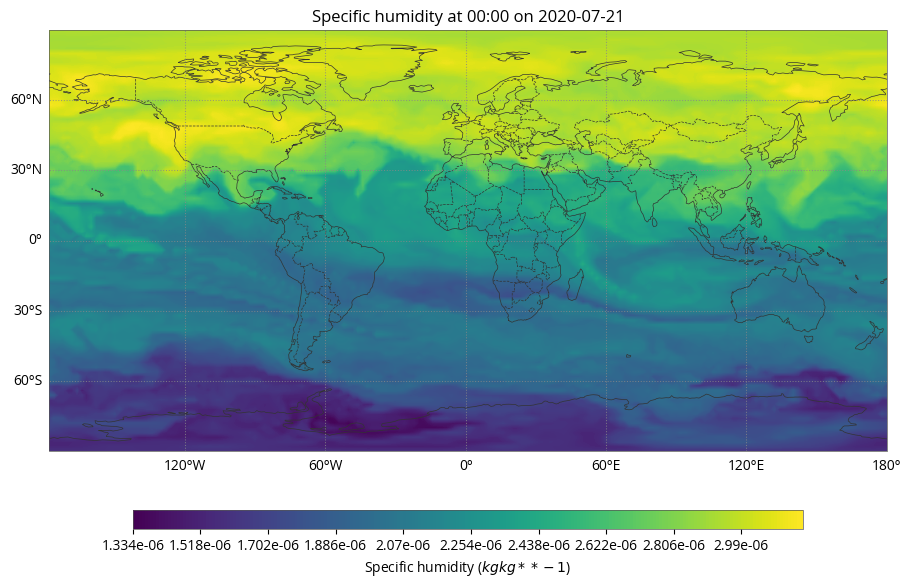

In [19]:
earthkit.maps.quickplot(da_transform, style=earthkit.maps.Style(
    colors="viridis",
    levels=earthkit.maps.styles.levels.auto_range(da_transform, n_levels=256),
));

## Plot the ZFP compression error

/lib/python3.11/site-packages/earthkit/maps/metadata/__init__.py:89: UserWarning: No key "variable_name" found in layer metadata.
  warnings.warn(f'No key "{attr}" found in layer metadata.')
/lib/python3.11/site-packages/earthkit/maps/metadata/__init__.py:89: UserWarning: No key "units" found in layer metadata.
  warnings.warn(f'No key "{attr}" found in layer metadata.')


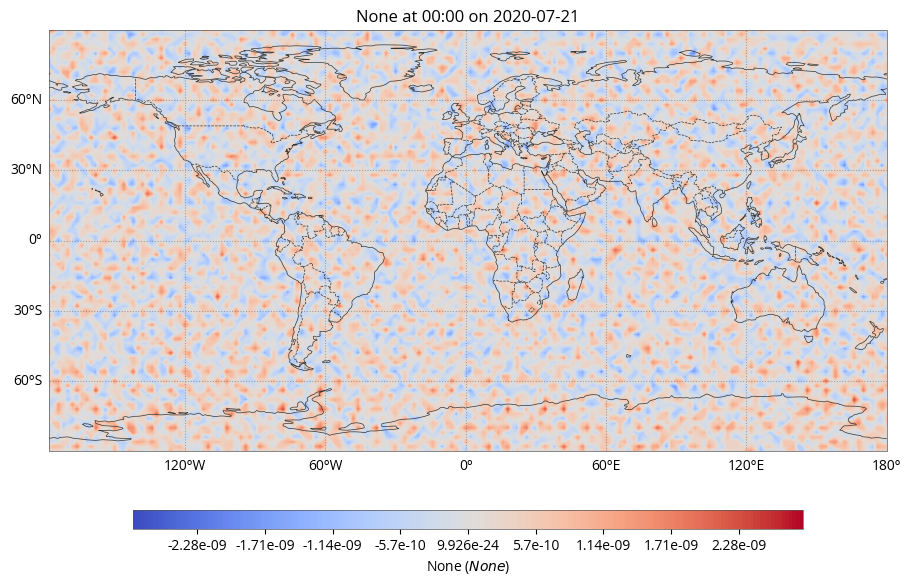

In [20]:
da_transform_error = da_transform - da
earthkit.maps.quickplot(da_transform_error, style=earthkit.maps.Style(
    colors="coolwarm",
    levels=earthkit.maps.styles.levels.auto_range(da_transform_error, n_levels=256, divergence_point=0.0),
));

## Run the prediction-based SZ3 compressor

SZ3 is a lossy prediction-based compressor that compresses multidimensional data by predicting the next value based on an indentified pattern. The quantized prediction errors are stored alongside the pattern. SZ3 is a modular compression pipeline that combines a data preprocessor, predictor, quantizer, encoder, and lossless compressor. The compression error can be bounded with absolute, relative, and PWR error bounds.

You can find out more about the SZ3 compressor in the following publications:

> Liang, X. et *al*. (2023). SZ3: A modular framework for composing prediction-based error-bounded lossy compressors. *IEEE Transactions on Big Data*. 9(2). pp. 485-498. Available from: [doi:10.1109/TBDATA.2022.3201176](https://doi.org/10.1109/TBDATA.2022.3201176).

> Zhao, K. et *al*. (2021). Optimizing Error-Bounded Lossy Compression for Scientiﬁc Data by Dynamic Spline Interpolation. In: *Proceeding of the 37th IEEE International Conference on Data Engineering*. pp. 1643-1654. Available from: [doi:10.1109/ICDE51399.2021.00145](https://doi.org/10.1109/ICDE51399.2021.00145).

> Liang, X. et *al*. (2018). Error-Controlled Lossy Compression Optimized for High Compression Ratios of Scientific Datasets. *IEEE International Conference on Big Data*. pp. 438-447. Available from: [doi:10.1109/BigData.2018.8622520](https://doi.org/10.1109/BigData.2018.8622520).

In [21]:
predict_compressor = [fcbench.codecs.Sz3(eb_mode="abs", eb_abs=1e-8)]
da_predict, stats_predict = fcbench.compressor.compute_dataarray_compress_decompress(da, predict_compressor)
format_compress_stats(predict_compressor, stats_predict)

compression ratio [raw B / enc B]  \
Codec                                                                 
Sz3(eb_mode='abs', eb_abs=1e-08)                              20.38   

                                  encode throughput [raw GB/s]  \
Codec                                                            
Sz3(eb_mode='abs', eb_abs=1e-08)                          0.04   

                                  decode throughput [raw GB/s]  \
Codec                                                            
Sz3(eb_mode='abs', eb_abs=1e-08)                          0.08   

                                  encode instructions [#/B]  \
Codec                                                         
Sz3(eb_mode='abs', eb_abs=1e-08)                       14.3   

                                  decode instructions [#/B]  
Codec                                                        
Sz3(eb_mode='abs', eb_abs=1e-08)                        5.6

In [22]:
del predict_compressor

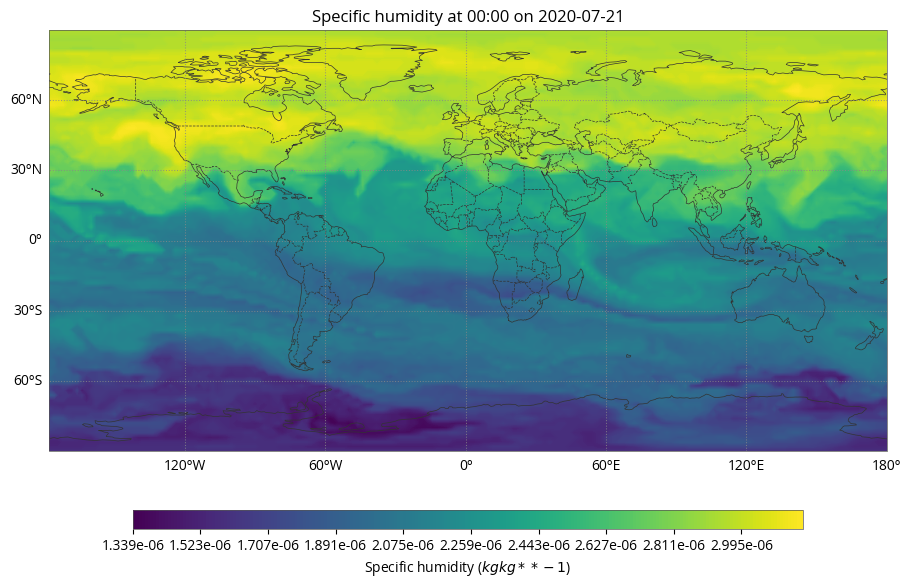

In [23]:
earthkit.maps.quickplot(da_predict, style=earthkit.maps.Style(
    colors="viridis",
    levels=earthkit.maps.styles.levels.auto_range(da_predict, n_levels=256),
));

## Plot the SZ3 compression error

/lib/python3.11/site-packages/earthkit/maps/metadata/__init__.py:89: UserWarning: No key "variable_name" found in layer metadata.
  warnings.warn(f'No key "{attr}" found in layer metadata.')
/lib/python3.11/site-packages/earthkit/maps/metadata/__init__.py:89: UserWarning: No key "units" found in layer metadata.
  warnings.warn(f'No key "{attr}" found in layer metadata.')


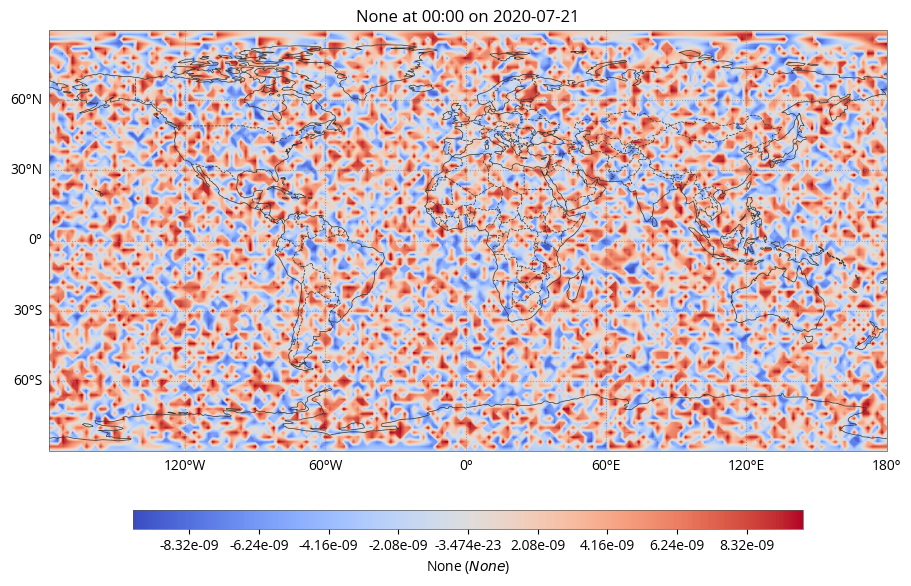

In [24]:
da_predict_error = da_predict - da
earthkit.maps.quickplot(da_predict_error, style=earthkit.maps.Style(
    colors="coolwarm",
    levels=earthkit.maps.styles.levels.auto_range(da_predict_error, n_levels=256, divergence_point=0.0),
));

## Save the dataset for further use

If you want to perform further work on the (compressed) data outside or in a new session of the compression lab, you can download the data to your computer. Note that the writes are directly streamed to the download and it is thus not possible to skip around the file (seek) or read written back during the download.

### (a) Download the compressed data

You can save the compressed dataset as a single `.zip` file in the [ZARR format](https://zarr.readthedocs.io/en/stable/spec.html). Note that this approach takes the uncompressed dataset and runs the provided compression as the dataset is downloaded.

For instance, here we download the dataset compressed using the SZ3 compressor from above. You can also download the uncompressed dataset by passing `compressor=[]` to the following helper function:
```python
await download_dataset_as_zarr(
    ds: xr.Dataset,
    name: str,
    compressor: Union[
        numcodecs.abc.Codec,
        list[numcodecs.abc.Codec],
        dict[str, Union[
            numcodecs.abc.Codec,
            list[numcodecs.abc.Codec],
        ]],
    ],
    zip_compression: int = 0,
)
```

In [25]:
from pathlib import Path

compressed_download_name = Path(ds.attrs.get("path", "ds")).name
compressed_download_name = compressed_download_name[:compressed_download_name.find('.')]
compressed_download_name = f"{compressed_download_name}-compressed.zarr.zip"
compressed_download_name

'hplp_ml_q_dx=2-compressed.zarr.zip'

In [26]:
await download_dataset_as_zarr(ds, compressed_download_name, compressor=[fcbench.codecs.BitRound(keepbits=8)])

### (b) Download arbitrary files

You can also download arbitrary files. The compression lab provides the following (asynchronous context manager) construct to obtain a file system path to which the to-be-downloaded file can be written inside the `async with` block:
```python
async with file_download_path("my-file.txt") as download_path:
    with open(download_path, "w") as download:
        download.write("Hello world!")
```
Note again that the special download files do not provide random access but are append-only streams. Since, e.g. NetCDF file writes require random access, they cannot be directly downloaded but must go through a temporary file first (see option **(c)** below).

### (c) Download (small) files from the (in-memory) file system

If your file already exists within the file system, you can download them directly. For instance, you can download small files that are stored in the in-memory file system. If you want to download small files that need seeks or reads during writing, you can first write them to the in-memory file system and then download them.

For instance, here we create, write to, and then partially overwrite a text file, before we download it.

In [27]:
import io
import shutil

with open("demo.txt", "wb") as file:
    file.write(b"This text is wrong")
    file.seek(-len(b"wrong"), io.SEEK_CUR)
    file.write(b"correct")

async with file_download_path("demo.txt") as download_path:
    shutil.copyfile("demo.txt", download_path)

## Feedback on the ESiWACE3 Compression Lab

We aim to build an online compression laboratory in which you can easily test and apply the most relevant compression algorithms on your data. We want to hear from you about what your requirements for compression are to ensure that any downstream scientific analysis is not adversely affected.

Please use the below link to provide us with feedback on
- your requirements for compression
- any bugs in the compression lab
- missing features that would allow you to better use it (e.g. unsupported data formats, compression methods, or compression error analysis methods)
- complicated or unclear functionality in the compression lab

https://forms.office.com/e/hKqfmvFTkz